In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import torch
from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator, VarianceSource,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.models import EpistemicPredictor, MCDropout
from torch.utils.data import DataLoader, TensorDataset


In [3]:
def oracle(x, noise=0.1):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
        return (2 * np.pi * x).sin() + noise * m

def generate_data(n=1024, sep=1):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0)
        # x = torch.zeros(n, 1).uniform_(0, 2)
        x_test = torch.linspace(-3, 5, 1024).view(-1, 1)
        ood_x = torch.FloatTensor(24, 1).uniform_(0.5, 1.5)
        ood_x = torch.cat((ood_x, torch.FloatTensor(12, 1).uniform_(-2, 0)), 0)
        ood_x = torch.cat((ood_x, torch.FloatTensor(12, 1).uniform_(2, 4)), 0)
        y = oracle(x)
        y2 = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, y2, x_test, y_test_true, ood_x, ood_y

x, y, y2, x_test, y_test, ood_x, ood_y = generate_data()


In [36]:
density_estimator = CVKernelDensityEstimator(use_log_density=False)
features = 'xDv'
networks = {'a_predictor': create_network(1, 1, 512, 'tanh', True),
            'e_predictor': create_network(len(features), 1, 512, 'relu', True, 3),
            'f_predictor': create_network(1, 1, 512, 'relu', False)
            }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-2),
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-3),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
              }
mcdrop_network = create_network(1, 1, 64, dropout_prob=0.5)
mcdrop_optimizer = create_optimizer(mcdrop_network, 1e-3)
var_model = MCDropout(x, y, mcdrop_network, mcdrop_optimizer)
variance_source = VarianceSource(var_model, num_samples=10)

model = EpistemicPredictor(train_X=x,
                           train_Y=y,
                           networks=networks,
                           optimizers=optimizers,
                           density_estimator=density_estimator,
                           variance_source=variance_source,
                           train_Y_2=y2,
                           ood_X=ood_x,
                           ood_Y=ood_y,
                           bounds=(-2, 5),
                           features=features,
                          retrain=False)
variance_source.fit()

In [37]:
model.pretrain_density_estimator(x)

In [38]:
density_estimator.score_samples(x_test)

tensor([[0.0859],
        [0.0878],
        [0.0898],
        [0.0918],
        [0.0938],
        [0.0958],
        [0.0978],
        [0.0999],
        [0.1019],
        [0.1040],
        [0.1060],
        [0.1081],
        [0.1102],
        [0.1123],
        [0.1144],
        [0.1165],
        [0.1186],
        [0.1208],
        [0.1229],
        [0.1251],
        [0.1273],
        [0.1294],
        [0.1316],
        [0.1339],
        [0.1361],
        [0.1383],
        [0.1405],
        [0.1428],
        [0.1450],
        [0.1473],
        [0.1496],
        [0.1519],
        [0.1541],
        [0.1564],
        [0.1587],
        [0.1611],
        [0.1634],
        [0.1657],
        [0.1680],
        [0.1704],
        [0.1727],
        [0.1751],
        [0.1774],
        [0.1798],
        [0.1822],
        [0.1846],
        [0.1870],
        [0.1895],
        [0.1919],
        [0.1943],
        [0.1968],
        [0.1992],
        [0.2017],
        [0.2042],
        [0.2066],
        [0

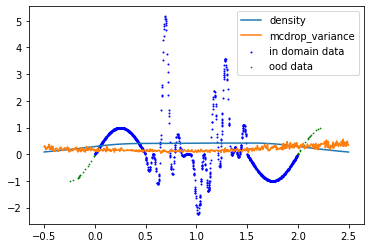

In [39]:
plt.scatter(x, y, color='b', s=1, label='in domain data')
plt.scatter(ood_x, ood_y, color='g', s=.5, label='ood data')
try:
    plt.plot(x_test, density_estimator.score_samples(x_test), label='density')
except:
    pass
plt.plot(x_test, variance_source.score_samples(x_test), label='mcdrop_variance')
# plt.plot(x_test, model.distance_estimator.score_samples(x_test), label='distance')

plt.legend()
plt.show()


In [40]:
epochs = 100
losses = {'a': [], 'e': [], 'f': []}

for i in range(epochs):
    print(i)
    new_losses = model.fit()
    for key in 'afe':
        losses[key].extend(new_losses[key])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [41]:
for i in range(epochs * 5):
    new_losses = model.fit_ood()
    for key in 'e':
        losses[key].extend(new_losses[key])

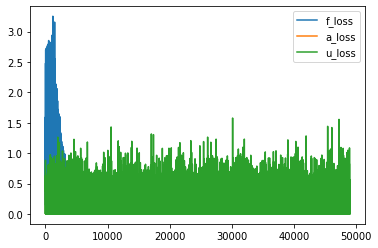

In [42]:
plt.plot(losses['f'], label='f_loss')
plt.plot(losses['a'], label='a_loss')
plt.plot(losses['e'], label='u_loss')
plt.legend()
plt.show()

In [43]:
predictions = networks['f_predictor'](x_test).detach().numpy().ravel()

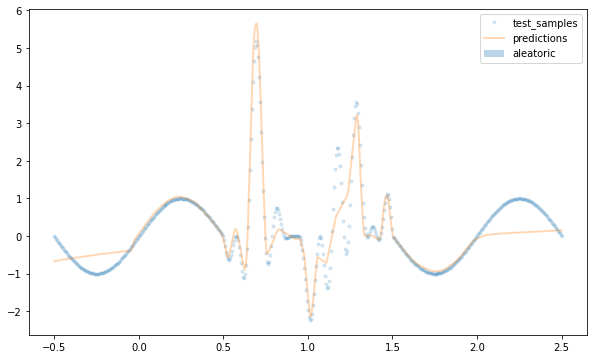

In [44]:
plt.figure(figsize=(10, 6))

aleatoric_u = networks['a_predictor'](x_test).detach().numpy().ravel()
a_low = predictions - np.sqrt(aleatoric_u)
a_high = predictions + np.sqrt(aleatoric_u)

plt.plot(x_test, y_test, '.', label='test_samples', alpha=.15)
plt.plot(x_test, predictions, label='predictions', alpha=.3, lw=2)
plt.fill_between(x_test.numpy().ravel(), a_low, a_high, alpha=.3, label='aleatoric')


epistemic_u = model._epistemic_uncertainty(x_test).detach().numpy().ravel()

e_low = predictions - np.sqrt(epistemic_u)
e_high = predictions + np.sqrt(epistemic_u)

# plt.fill_between(x_test.numpy().ravel(), e_low, e_high, alpha=.3, label='epistemic')

exp_epistemic_uncertainty = (networks['f_predictor'](x_test) - y_test).pow(2).detach().numpy().ravel()
exp_total_uncertainty = exp_epistemic_uncertainty + 0.1 ** 2  # squaring noise to get variance !!

exp_e_low = predictions - np.sqrt(exp_epistemic_uncertainty)
exp_e_high = predictions + np.sqrt(exp_epistemic_uncertainty)

# plt.fill_between(x_test.numpy().ravel(), exp_e_low, exp_e_high, alpha=.15, label='out of sample error')
plt.legend()
plt.show()

total_uncertainty = epistemic_u + aleatoric_u


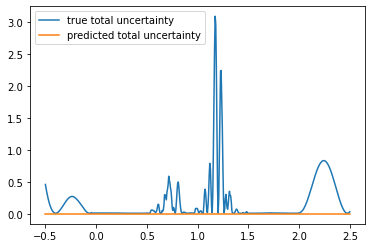

In [45]:
plt.plot(x_test, exp_total_uncertainty, label='true total uncertainty')
plt.plot(x_test, total_uncertainty, label='predicted total uncertainty')
plt.legend()
plt.show()

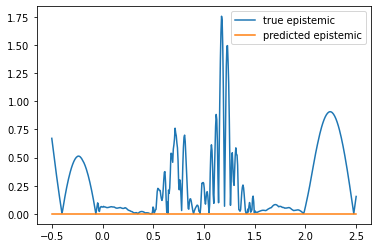

In [46]:
plt.plot(x_test.view(-1).numpy(), np.sqrt(exp_epistemic_uncertainty), label='true epistemic')
plt.plot(x_test.view(-1).numpy(), np.sqrt(epistemic_u), label='predicted epistemic')
# plt.plot(x_test, np.sqrt(epistemic_mcdrop), label='MCDropout epistemic')

plt.legend()
plt.show()

In [ ]:
network = create_network(1, 1, 64, 'relu', False, dropout_prob=.4)
optimizer = create_optimizer(network, 1e-3, weight_decay=1e-4)

mcdropout = MCDropout(torch.cat([x, ood_x]), torch.cat([y, ood_y]), network, optimizer)
losses = []
for epoch in range(700):
    losses.append(mcdropout.fit()['f'])
plt.plot(losses)
epistemic_mcdrop = mcdropout._epistemic_uncertainty(x_test)

In [ ]:
model.e_predictor.input_layer.in_features

In [32]:
def oracle(x, noise=0):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
    return torch.where(torch.logical_and(x > 0.5, x < 1.5), torch.sin(x) * torch.cos(5 * x) * torch.cos(22 * x) * -3 * torch.sin(7 * x) * torch.cos(19 * x) * 4 * torch.sin(11 * x), (2 * np.pi * x).sin()) + noise * m

def generate_data(n=1024, sep=1):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(0.5 + sep, 1 + sep)), 0)
        x = torch.cat((x, torch.zeros(512, 1).uniform_(0.5, 1.5)), 0)
        x_test = torch.linspace(-0.5, 2.5, 512).view(-1, 1)
        ood_x = torch.zeros(16, 1).uniform_(-0.25, 0.0)
        ood_x = torch.cat((ood_x, torch.zeros(16, 1).uniform_(2, 2.25)), 0)
#         ood_x = torch.cat((ood_x, torch.zeros(64, 1).uniform_(0.5, 1.5)), 0)
        y = oracle(x)
        y2 = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, y2, x_test, y_test_true, ood_x, ood_y

x, y, y2, x_test, y_test, ood_x, ood_y = generate_data(1024)

In [33]:
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [34]:
model = SingleTaskGP(x, y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

c:\users\moksh\miniconda3\envs\ul\lib\site-packages\gpytorch\distributions\multivariate_normal.py:230: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


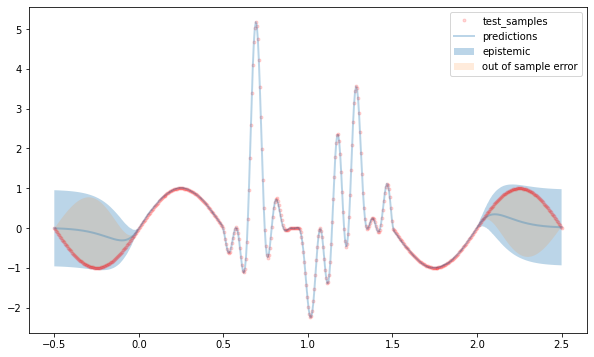

In [35]:
y_preds = model(x_test)

plt.figure(figsize=(10, 6))

plt.plot(x_test, y_test, '.', label='test_samples', alpha=.15, color='red')
plt.plot(x_test, y_preds.mean.detach(), label='predictions', alpha=.3, lw=2)

e_low = (y_preds.mean - y_preds.stddev).detach()
e_high = (y_preds.mean + y_preds.stddev).detach()

plt.fill_between(x_test.numpy().ravel(), e_low, e_high, alpha=.3, label='epistemic')

exp_epistemic_uncertainty = (y_preds.mean.detach() - y_test.squeeze()).pow(2).detach().numpy().ravel()
exp_total_uncertainty = exp_epistemic_uncertainty + 0.1 ** 2  # squaring noise to get variance !!

exp_e_low = y_preds.mean.detach() - np.sqrt(exp_epistemic_uncertainty)
exp_e_high = y_preds.mean.detach() + np.sqrt(exp_epistemic_uncertainty)

plt.fill_between(x_test.numpy().ravel(), exp_e_low, exp_e_high, alpha=.15, label='out of sample error')

plt.legend()
plt.show()